In [23]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
desired_res = (32, 32, 32)

In [18]:
# Desired resolution (modify as needed)

knot_types = {
        'standard_14': 0,  # 2
        'standard_16': 1,  # 1
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        # 'dennis': 9,
        'trefoil_standard_12': 9,
        'trefoil_optimized': 10,
        # 'fivefoil_standard_08': fivefoil_standard_08

}


knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', #'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]

folders = [
    '../HOPFS_L270_0.05_100_64x64x64_v1',
    '../HOPFS_L270_0.15_100_64x64x64_v1',
    '../HOPFS_L270_0.25_100_64x64x64_v1',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True


# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Deserialize the JSON string back to a list
                    data_list = json.loads(row[0])
                    data_array = np.array(data_list)

                    # Extract points and dimensions
                    points_list = data_array[2:]
                    Nx, Ny, Nz = data_array[1]

                    if flag_print_shape:
                        print(f'Shape: {Nx}, {Ny}, {Nz}')
                        flag_print_shape = False

                    # Rescale if necessary
                    if desired_res != (Nx, Ny, Nz):
                        scale_x = desired_res[0] / Nx
                        scale_y = desired_res[1] / Ny
                        scale_z = desired_res[2] / Nz
                        points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

                    # Initialize a 3D array and set points to 1
                    dots_3d = np.zeros(desired_res, dtype=int)
                    for x, y, z in points_list:
                        try:
                            dots_3d[x, y, z] = 1
                        except IndexError:
                            continue

                    # Append to lists
                    X_list.append(dots_3d)
                    Y_list.append(knot_types[knot])

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 64
Loaded 3300 samples.  300 per class


In [19]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch_dots = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_dots = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch_dots.shape, y_dots.shape)
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
test_dataset_dots = TensorDataset(X_torch_dots, y_dots)

torch.Size([3300, 1, 32, 32, 32]) torch.Size([3300, 11])


In [20]:
# train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'])

In [21]:

num_classes = len(knots)
X_list = []
Y_list = []
Xs_list = []
Ys_list = []

# csv.field_size_limit(10000000)

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_{knot}_spectr.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Append the knot label to Ys_list
					Ys_list.append(knot_types[knot])

					# Load the data array from the JSON string
					data_array = json.loads(row[0])

					# Extract values from the data array
					l1, l2 = data_array[0], data_array[1]
					p1, p2 = data_array[2], data_array[3]

					# Create and normalize the moments array
					moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
					moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
					moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

					# Append the flattened absolute values to Xs_list
					Xs_list.append(np.abs(moments.reshape(-1)))

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_spec = torch.tensor(Xs_np).float()
y_t = torch.tensor(ys_np)
y_spec = F.one_hot(y_t.long(), num_classes=num_classes).float()
print(Xs_spec.shape, y_spec.shape)
input_size = Xs_np.shape[-1]
# X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
test_dataset_spec = TensorDataset(Xs_spec, y_spec)
test_loader_spec = DataLoader(test_dataset_spec, batch_size=hyperparams['batch_size'])

Loaded 0 samples.  0 per class
torch.Size([3300, 91]) torch.Size([3300, 11])


In [25]:

# Load the saved model
model_path = "classifier_knots_3d_32_full_3.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")
print(stages, pooling_configs, num_classes)

Model loaded and ready for inference!
[[(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)], [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]] [(2, 2, 1), (2, 2, 1)] 11


In [27]:
from torchsummary import summary
summary(model_3D, input_size=(1, 32, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 32, 32, 32]             896
       BatchNorm3d-2       [-1, 32, 32, 32, 32]              64
              ReLU-3       [-1, 32, 32, 32, 32]               0
            Conv3d-4       [-1, 32, 32, 32, 32]          27,680
       BatchNorm3d-5       [-1, 32, 32, 32, 32]              64
              ReLU-6       [-1, 32, 32, 32, 32]               0
            Conv3d-7       [-1, 32, 32, 32, 32]          27,680
       BatchNorm3d-8       [-1, 32, 32, 32, 32]              64
              ReLU-9       [-1, 32, 32, 32, 32]               0
        MaxPool3d-10       [-1, 32, 17, 17, 17]               0
           Conv3d-11       [-1, 64, 15, 15, 15]         256,064
      BatchNorm3d-12       [-1, 64, 15, 15, 15]             128
             ReLU-13       [-1, 64, 15, 15, 15]               0
           Conv3d-14       [-1, 64, 13,

In [28]:
input_size = 91
# Load the saved model
model_path = "classifier_new_spec10_full_3.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
hidden_sizes1 = checkpoint['hidden_sizes1']
hidden_sizes2 = checkpoint['hidden_sizes2']
hidden_sizes3 = checkpoint['hidden_sizes3']
num_classes = checkpoint['num_classes']
num_hidden = checkpoint['num_hidden']
print(hidden_sizes1, hidden_sizes2, hidden_sizes3, num_classes, num_hidden)

# Initialize the model and load the saved state dict
model_FC = ClassifierFC_spec(input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3, num_hidden, num_classes=num_classes).to(device)
model_FC.load_state_dict(checkpoint['model_state_dict'])
model_FC.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

128 1024 128 11 10
Model loaded and ready for inference!


In [40]:
model_FC(torch.rand((1, 91)).to(device))

tensor([[ 0.9478, -3.8194, -7.0831, -8.9952,  1.9994, -1.4430, -3.1433, -5.5754,
         -0.4911, -3.1186, -4.4922]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [42]:
summary(model_FC, input_size=(91,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          11,776
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                 [-1, 1024]         132,096
       BatchNorm1d-6                 [-1, 1024]           2,048
              ReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
      BatchNorm1d-10                 [-1, 1024]           2,048
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600
      BatchNorm1d-14                 [-

In [44]:
# Load the saved model
model_path = "classifier_spec10_conv_3.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']


# Initialize the model and load the saved state dict
model_2D = Classifier2D(stages, pooling_configs, num_classes=num_classes).to(device)
model_2D.load_state_dict(checkpoint['model_state_dict'])
model_2D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


In [45]:
summary(model_2D, input_size=(91, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 7, 13]             320
       BatchNorm2d-2            [-1, 32, 7, 13]              64
              ReLU-3            [-1, 32, 7, 13]               0
            Conv2d-4            [-1, 32, 7, 13]           9,248
       BatchNorm2d-5            [-1, 32, 7, 13]              64
              ReLU-6            [-1, 32, 7, 13]               0
            Conv2d-7            [-1, 32, 7, 13]           9,248
       BatchNorm2d-8            [-1, 32, 7, 13]              64
              ReLU-9            [-1, 32, 7, 13]               0
        MaxPool2d-10             [-1, 32, 4, 7]               0
           Conv2d-11             [-1, 64, 4, 7]          18,496
      BatchNorm2d-12             [-1, 64, 4, 7]             128
             ReLU-13             [-1, 64, 4, 7]               0
           Conv2d-14             [-1, 6

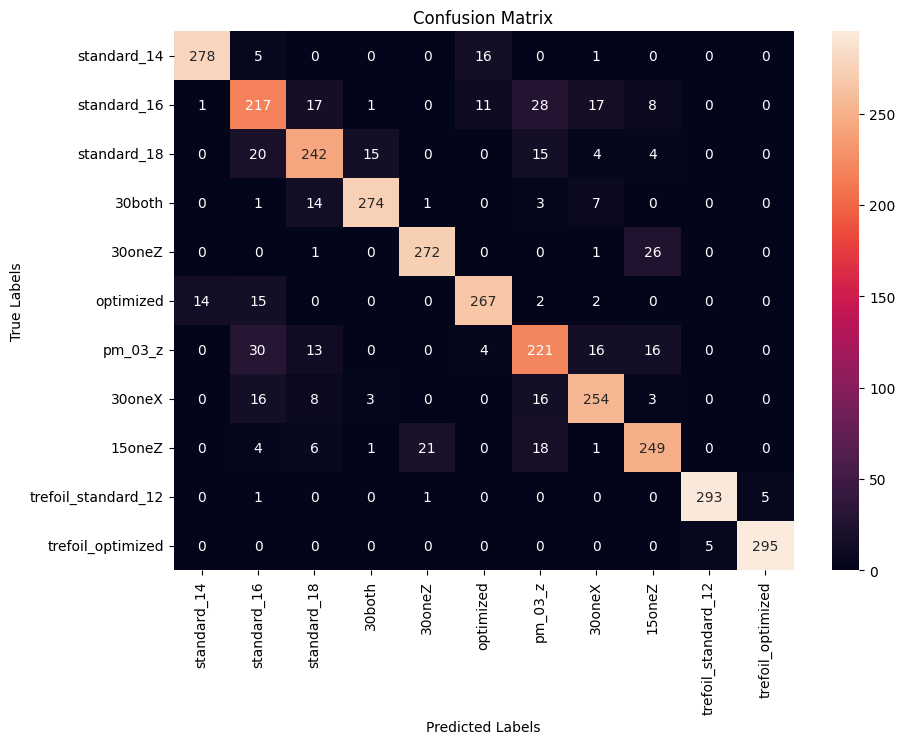

In [25]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_dots, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.8672727272727273


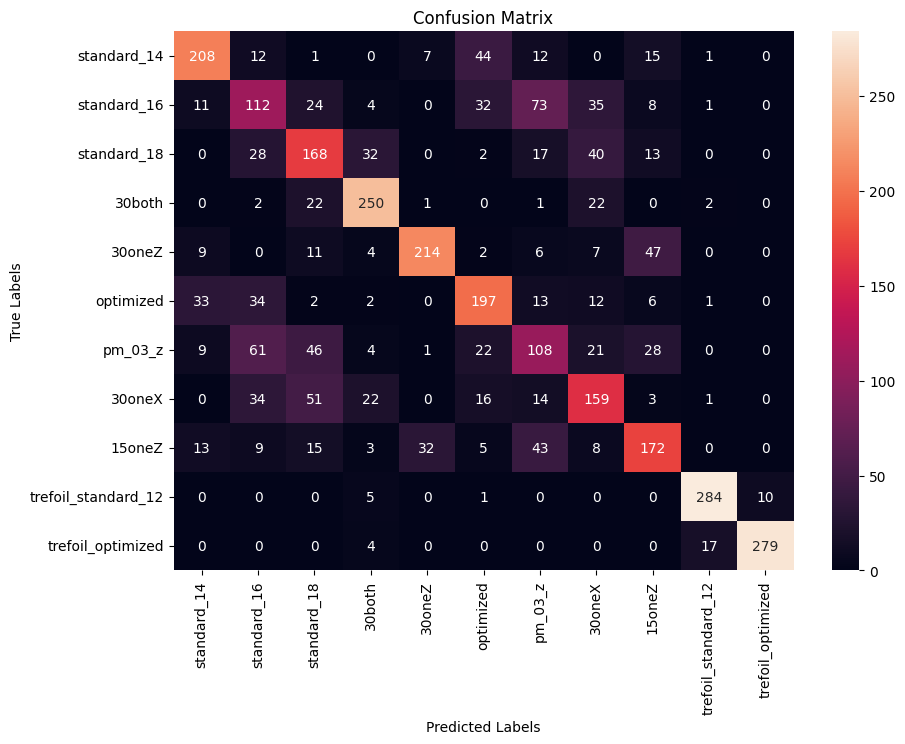

In [27]:
model_FC.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_spec:
        inputs = batch[0].to(device)
        outputs = model_FC(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_spec, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.6518181818181819


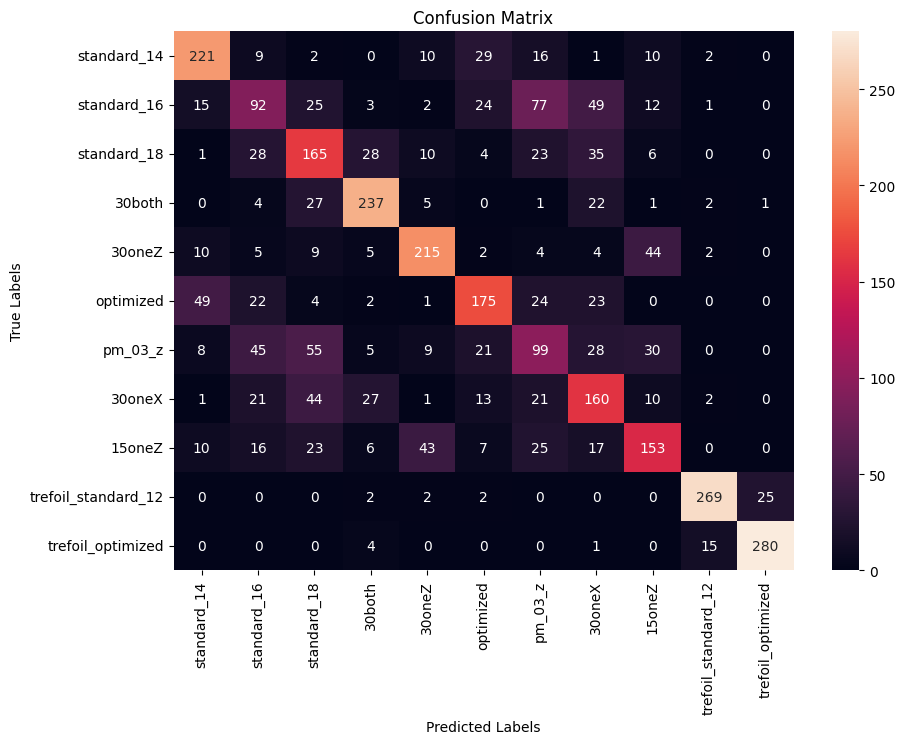

In [29]:

predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_spec:
        inputs = batch[0].to(device)
        outputs = model_2D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_spec, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [30]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.6260606060606061
